# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

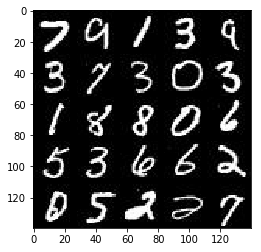

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

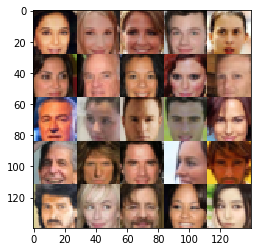

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [21]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(x1, x1*alpha)
#         print(x1.get_shape())
        
        x2 = tf.layers.conv2d(x1, 112, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha)
#         print(x2.get_shape())
        
        x3 = tf.layers.conv2d(x2, 224, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3*alpha)
#         print(x3.get_shape())
        
        flat = tf.reshape(x3, (-1, 4*4*224))
        
        logits = tf.layers.dense(flat, 1)
#         print(logits.get_shape())
        
        out = tf.sigmoid(logits)
        out = tf.nn.dropout(out, keep_prob=0.99)
        
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        
        x1 = tf.reshape(x1, (-1,3,3,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, x1 * alpha)
#         print(x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, x2 * alpha)
#         print(x2.get_shape())
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, x3 * alpha)
#         print(x3.get_shape())
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4, x4 * alpha)
#         print(x4.get_shape())
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
#         print(logits.get_shape())
        
        out = tf.tanh(logits)
        out = tf.nn.dropout(out, keep_prob=0.99)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
#     sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    show_every = 100
    print_every = 10
    step = 0
    samples, losses = [], []
    
    img_height = data_shape[1]
    img_width = data_shape[2]
    img_depth = data_shape[3]
    
    input_real, input_z, lr = model_inputs(img_height, img_width, img_depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        show_generator_output(sess, 25, input_z, img_depth, data_image_mode)
        saver = tf.train.Saver()
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                # show image at start
                
                
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                

                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, 25, input_z, img_depth, data_image_mode)
                
        saver.save(sess, './checkpoints/generator.ckpt')       
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [15]:
!mkdir 'checkpoints'

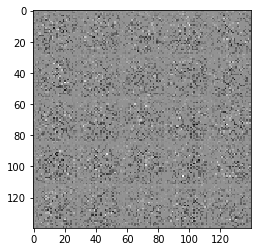

Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.6687
Epoch 1/2... Discriminator Loss: 0.4104... Generator Loss: 2.6258
Epoch 1/2... Discriminator Loss: 0.3760... Generator Loss: 3.2768
Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 3.4958
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 3.8112


KeyboardInterrupt: 

In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

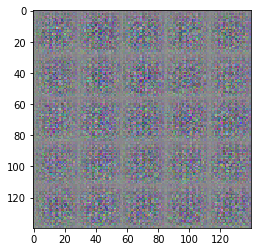

Epoch 1/1... Discriminator Loss: 4.4105... Generator Loss: 0.3628
Epoch 1/1... Discriminator Loss: 3.1853... Generator Loss: 0.3906
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.4173
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 2.3661
Epoch 1/1... Discriminator Loss: 1.8391... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.8679
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.5247


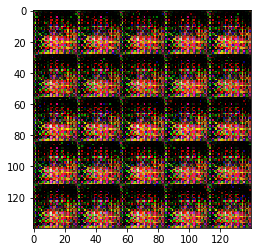

Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 1.9983
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 1.4687
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.8057
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.1979
Epoch 1/1... Discriminator Loss: 0.4864... Generator Loss: 2.4316
Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 1.7408
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.6772
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.5097
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 1.2562


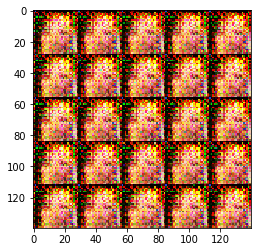

Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 1.8120
Epoch 1/1... Discriminator Loss: 0.5211... Generator Loss: 2.1717
Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 1.5174
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 2.4984
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 2.6748
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.3346
Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 1.6696
Epoch 1/1... Discriminator Loss: 0.5540... Generator Loss: 2.0762
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 2.4521
Epoch 1/1... Discriminator Loss: 0.3948... Generator Loss: 3.3350


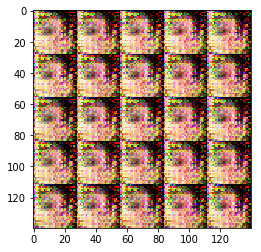

Epoch 1/1... Discriminator Loss: 1.8240... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.8056... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.5824... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.9344... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.8580... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.8996... Generator Loss: 0.5321


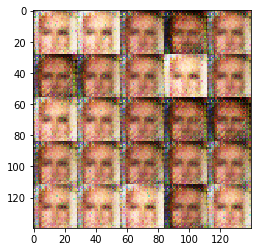

Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7615


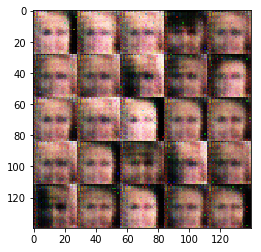

Epoch 1/1... Discriminator Loss: 1.7283... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.6644


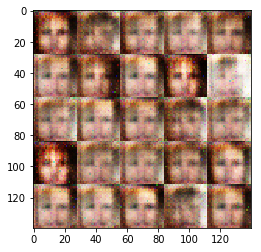

Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.7541... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.6890... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.8097


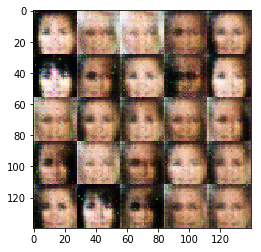

Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.7139... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7310


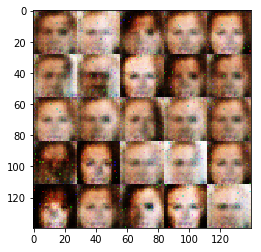

Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.8768
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 1.0695


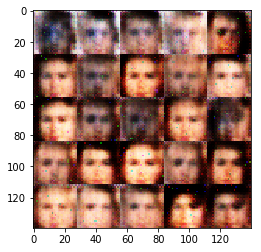

Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.5557
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.6743... Generator Loss: 0.4326
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.9769... Generator Loss: 0.4331


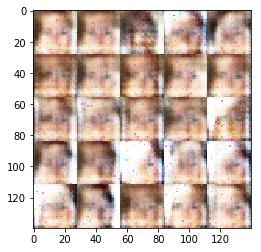

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 1.4344
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.6994


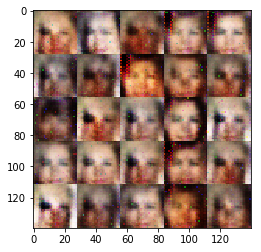

Epoch 1/1... Discriminator Loss: 1.7128... Generator Loss: 0.4469
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.2021
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.4791


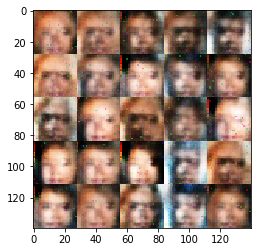

Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.7970


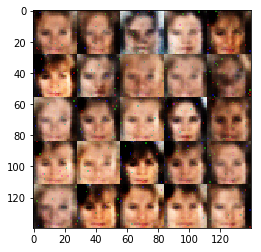

Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 2.1338... Generator Loss: 0.4489
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 2.4658... Generator Loss: 1.4082
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7911


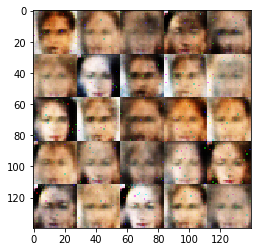

Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.0388


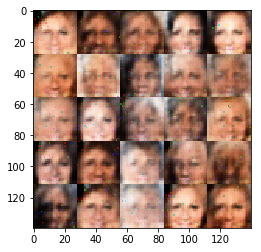

Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 2.2767... Generator Loss: 0.3608


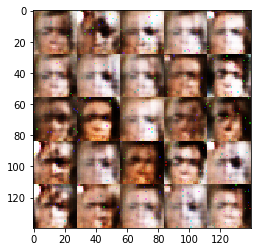

Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.6134
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 1.4361
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.8705... Generator Loss: 2.4518
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.2098
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.7934


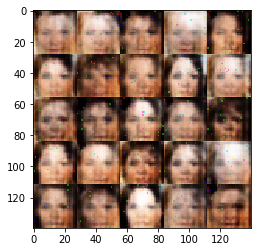

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 2.0633
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 1.9657
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 1.1846
Epoch 1/1... Discriminator Loss: 1.8726... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 1.6689... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.9318


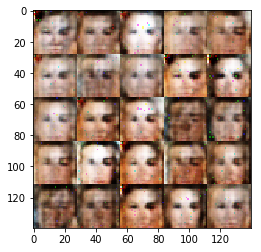

Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 1.6188
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 2.1859
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 2.3830
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 2.3352
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 1.2712


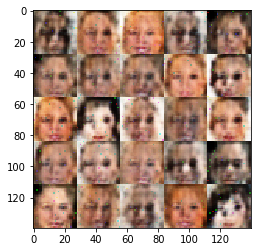

Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.2970
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 1.3907
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.9501
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.9722
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 2.7034
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 1.1999
Epoch 1/1... Discriminator Loss: 1.6555... Generator Loss: 0.3881
Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.3823


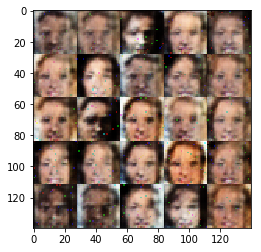

Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 2.3212
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 2.0909
Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 1.3301
Epoch 1/1... Discriminator Loss: 2.0659... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.9552


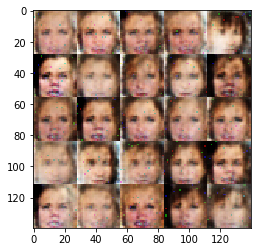

Epoch 1/1... Discriminator Loss: 0.5833... Generator Loss: 2.1371
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 2.0685
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 2.5195
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 1.9199
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.3504
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 1.4697
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.5671
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 2.4195
Epoch 1/1... Discriminator Loss: 0.4787... Generator Loss: 3.0434


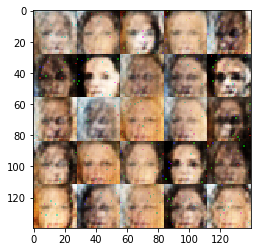

Epoch 1/1... Discriminator Loss: 0.5234... Generator Loss: 1.8141
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 2.3991
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 1.4889
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 2.4916
Epoch 1/1... Discriminator Loss: 0.4516... Generator Loss: 2.9944
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 1.9653
Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 1.9072
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 1.5517
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 2.2894


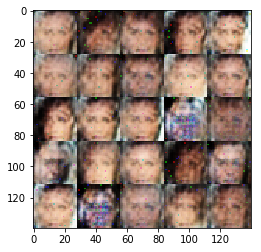

Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 3.2814
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 2.5964
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 4.7872
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.5823
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 3.1057
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 3.1865
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 2.8122
Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 3.6467


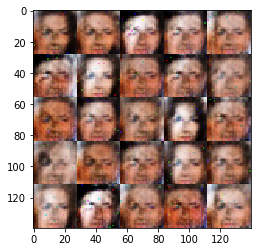

Epoch 1/1... Discriminator Loss: 1.8300... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 3.6087
Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 2.1267
Epoch 1/1... Discriminator Loss: 0.4140... Generator Loss: 2.7938
Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 3.9575
Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 2.0334
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 2.5281
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 2.2491
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 2.2472


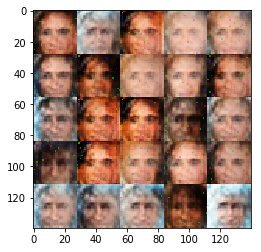

Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 2.4143
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 3.1165
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 3.4038
Epoch 1/1... Discriminator Loss: 0.3564... Generator Loss: 4.3342
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 2.0902
Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 2.1750
Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 2.9310
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 2.9700
Epoch 1/1... Discriminator Loss: 0.3787... Generator Loss: 3.8328
Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 1.4875


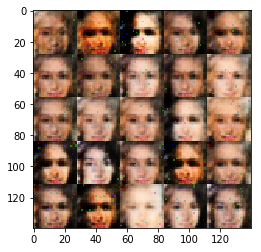

Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 2.6602
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 2.4009
Epoch 1/1... Discriminator Loss: 0.5159... Generator Loss: 1.9124
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.5309
Epoch 1/1... Discriminator Loss: 2.7055... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 2.5704
Epoch 1/1... Discriminator Loss: 0.6455... Generator Loss: 1.7138
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 2.2927
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 3.4618


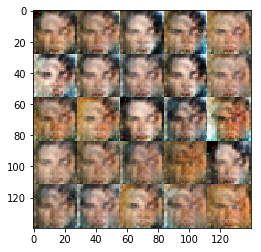

Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 5.0934
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.5142
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 3.1110
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 2.2747
Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 3.2356
Epoch 1/1... Discriminator Loss: 0.3699... Generator Loss: 3.2559
Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 3.2436
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 3.5441
Epoch 1/1... Discriminator Loss: 0.3609... Generator Loss: 3.9902


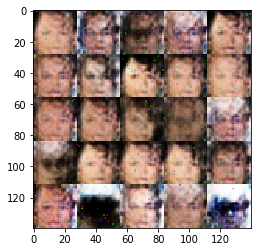

Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 2.6691
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 2.8771
Epoch 1/1... Discriminator Loss: 0.3802... Generator Loss: 2.9157
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 3.2612
Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 3.7137
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 2.0384
Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 5.5953
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 2.8742
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 1.0647
Epoch 1/1... Discriminator Loss: 0.5301... Generator Loss: 1.8269


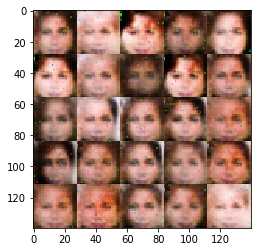

Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 1.7337
Epoch 1/1... Discriminator Loss: 0.4164... Generator Loss: 2.7391
Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 3.6567
Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 3.3823
Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 3.4752
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 4.6138
Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 4.9477
Epoch 1/1... Discriminator Loss: 0.3517... Generator Loss: 4.6208
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 4.4472
Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 4.7872


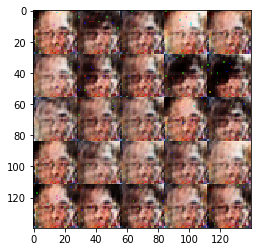

Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 3.2904
Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 3.8553
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 4.8238
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 3.4050
Epoch 1/1... Discriminator Loss: 0.4525... Generator Loss: 2.2991
Epoch 1/1... Discriminator Loss: 1.9399... Generator Loss: 3.6910
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 1.5409
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 2.6650
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 2.9498
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 3.5741


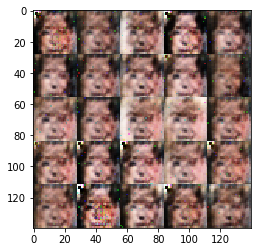

Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 2.8611
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 3.1201
Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 3.0735
Epoch 1/1... Discriminator Loss: 0.3578... Generator Loss: 3.5768
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 3.4785
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 4.7596
Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 3.3697
Epoch 1/1... Discriminator Loss: 0.3921... Generator Loss: 2.5343
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 4.1425
Epoch 1/1... Discriminator Loss: 0.3398... Generator Loss: 3.1299


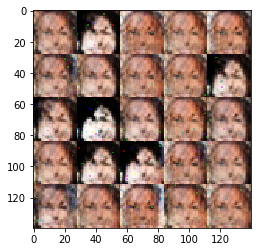

Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 4.4202
Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 3.3350
Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 5.2319
Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 3.7441
Epoch 1/1... Discriminator Loss: 0.3398... Generator Loss: 3.9569
Epoch 1/1... Discriminator Loss: 0.3487... Generator Loss: 4.1418
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 4.1734
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 4.7696
Epoch 1/1... Discriminator Loss: 0.3336... Generator Loss: 3.7376
Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 4.6492


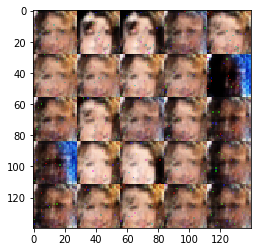

Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 2.0795
Epoch 1/1... Discriminator Loss: 0.3368... Generator Loss: 4.7508
Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 7.0249
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 3.6149
Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 5.1474
Epoch 1/1... Discriminator Loss: 0.3367... Generator Loss: 5.0397
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 1.6635
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 4.0661
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 2.6327
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 3.9579


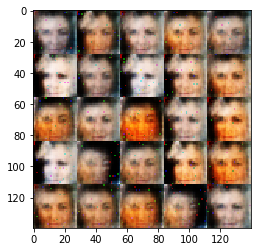

Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 2.6290
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 4.1671
Epoch 1/1... Discriminator Loss: 0.3364... Generator Loss: 4.5231
Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 5.3970
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 4.4152
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 4.8054
Epoch 1/1... Discriminator Loss: 0.3355... Generator Loss: 5.3409
Epoch 1/1... Discriminator Loss: 0.3361... Generator Loss: 4.1183
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 4.5480
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 4.5878


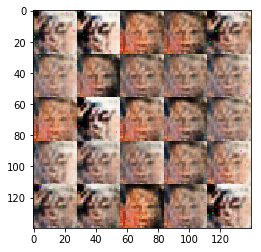

Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 4.7153
Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 4.9270
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 5.0121
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 3.0732
Epoch 1/1... Discriminator Loss: 0.3374... Generator Loss: 6.0231
Epoch 1/1... Discriminator Loss: 0.3312... Generator Loss: 5.8151
Epoch 1/1... Discriminator Loss: 0.3334... Generator Loss: 5.8538
Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 3.5070
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 1.7711


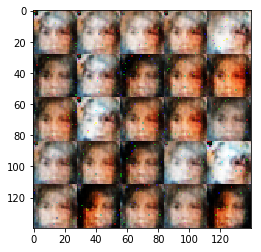

Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 1.5408
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.2211
Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 2.1510
Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 2.1084
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 3.8319
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 1.9728
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 1.6681
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 4.7264
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 3.8922


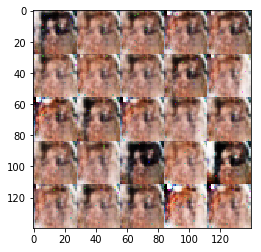

Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 4.3437
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 3.8418
Epoch 1/1... Discriminator Loss: 0.4163... Generator Loss: 2.9178
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 3.1253
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 5.0812
Epoch 1/1... Discriminator Loss: 0.3377... Generator Loss: 5.0756
Epoch 1/1... Discriminator Loss: 0.3492... Generator Loss: 4.9434
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 4.5387
Epoch 1/1... Discriminator Loss: 0.3629... Generator Loss: 3.5747
Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 3.0117


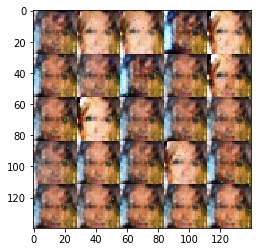

Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 3.8104
Epoch 1/1... Discriminator Loss: 0.3367... Generator Loss: 5.3194
Epoch 1/1... Discriminator Loss: 0.3374... Generator Loss: 4.1113
Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 5.1717
Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 4.9214
Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 3.6666
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 5.1390
Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 4.9128
Epoch 1/1... Discriminator Loss: 0.3377... Generator Loss: 4.4139
Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 4.9270


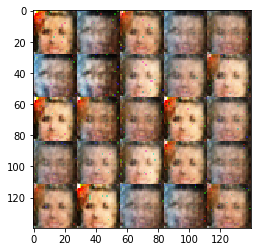

Epoch 1/1... Discriminator Loss: 0.3365... Generator Loss: 4.5319
Epoch 1/1... Discriminator Loss: 0.3374... Generator Loss: 5.7995
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 3.7899
Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 5.7275
Epoch 1/1... Discriminator Loss: 0.3728... Generator Loss: 2.8236
Epoch 1/1... Discriminator Loss: 0.3398... Generator Loss: 4.5277
Epoch 1/1... Discriminator Loss: 0.3358... Generator Loss: 4.8414
Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 4.7098
Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 6.0098
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 5.5340


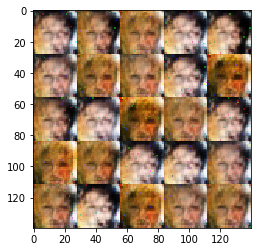

Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.4856
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.3007
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 3.3009... Generator Loss: 5.9893
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.1720
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 2.7939
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 2.4623


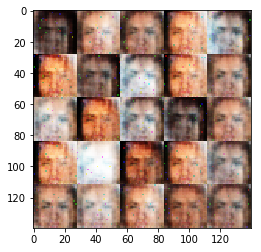

Epoch 1/1... Discriminator Loss: 0.4226... Generator Loss: 2.4760
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 1.3363
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 2.6958
Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 2.6215
Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 2.8137
Epoch 1/1... Discriminator Loss: 0.3840... Generator Loss: 3.1956
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 3.5918
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 2.7972
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 3.8237
Epoch 1/1... Discriminator Loss: 0.3402... Generator Loss: 5.5250


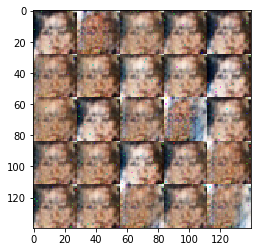

Epoch 1/1... Discriminator Loss: 0.3643... Generator Loss: 5.1065
Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 4.8645
Epoch 1/1... Discriminator Loss: 0.3479... Generator Loss: 3.5699
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 3.6213
Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 3.8040
Epoch 1/1... Discriminator Loss: 0.3423... Generator Loss: 5.0778
Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 5.7394
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 4.4509
Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 3.6073
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 5.1288


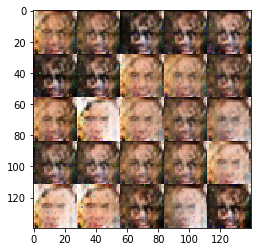

Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 4.0643
Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 3.9658
Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 4.5590
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 1.6168
Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 3.7424
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 2.9882
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 1.2775
Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 1.8607
Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 4.6626
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 2.8151


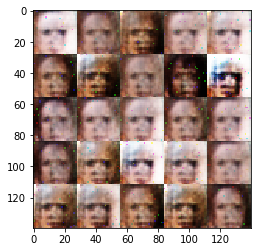

Epoch 1/1... Discriminator Loss: 0.3511... Generator Loss: 3.0039
Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 4.7575
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 3.4214
Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 4.4455
Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 4.6678
Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 4.1252
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 4.0383
Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 4.1062
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 4.0402
Epoch 1/1... Discriminator Loss: 0.3366... Generator Loss: 4.3298


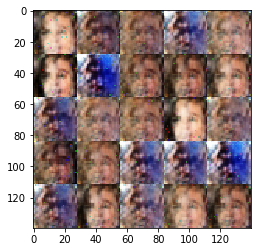

Epoch 1/1... Discriminator Loss: 0.3343... Generator Loss: 4.6932
Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 6.1837
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 4.4419
Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 3.8573
Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 3.6887
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 3.4195
Epoch 1/1... Discriminator Loss: 0.3500... Generator Loss: 3.8307
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 4.0944
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 2.3125
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.9674


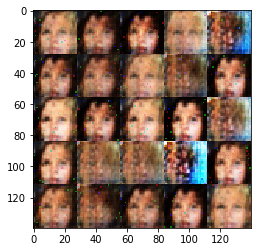

Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.2205
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 2.4651
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 2.2533
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 2.2196
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.8973


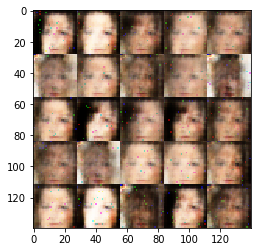

Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 2.0630
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 4.1314
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 4.3031
Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 4.5896
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 4.0213
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 3.1386
Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 4.1454
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 5.3899


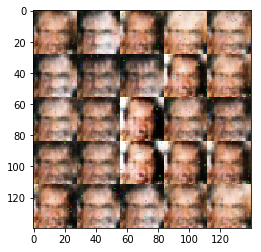

Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 3.3639
Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 4.5301
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 4.6678
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 3.4366
Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 3.4208
Epoch 1/1... Discriminator Loss: 0.3364... Generator Loss: 6.4396
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 3.0319
Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 4.2931
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 3.0542


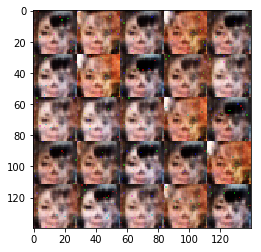

Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 4.7387
Epoch 1/1... Discriminator Loss: 0.3387... Generator Loss: 4.8830
Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 4.7224
Epoch 1/1... Discriminator Loss: 0.3654... Generator Loss: 3.5820
Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 4.9385
Epoch 1/1... Discriminator Loss: 0.3393... Generator Loss: 4.4910
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 2.2146
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 5.2238
Epoch 1/1... Discriminator Loss: 0.3373... Generator Loss: 6.0694
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 4.2144


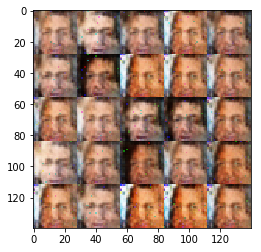

Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 3.1623
Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 4.7435
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 4.4611
Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 4.4775
Epoch 1/1... Discriminator Loss: 0.3607... Generator Loss: 4.3449
Epoch 1/1... Discriminator Loss: 0.3324... Generator Loss: 4.9675
Epoch 1/1... Discriminator Loss: 0.3358... Generator Loss: 4.7385
Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 5.0950
Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 5.0010
Epoch 1/1... Discriminator Loss: 0.3297... Generator Loss: 6.6663


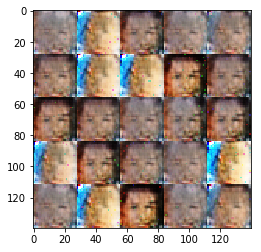

Epoch 1/1... Discriminator Loss: 0.3981... Generator Loss: 2.9374
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 4.8701
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 4.6927
Epoch 1/1... Discriminator Loss: 0.3402... Generator Loss: 4.5357
Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 5.4024
Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 5.5881
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 5.6919
Epoch 1/1... Discriminator Loss: 0.3359... Generator Loss: 4.7303
Epoch 1/1... Discriminator Loss: 0.3393... Generator Loss: 5.4750
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 7.2037


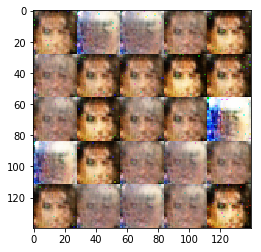

Epoch 1/1... Discriminator Loss: 0.3326... Generator Loss: 4.9008
Epoch 1/1... Discriminator Loss: 0.3304... Generator Loss: 5.7495
Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 4.5471
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 5.4835
Epoch 1/1... Discriminator Loss: 0.3377... Generator Loss: 4.0073
Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 4.6247
Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 3.8312
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 4.0333
Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 4.5339
Epoch 1/1... Discriminator Loss: 0.3500... Generator Loss: 3.9759


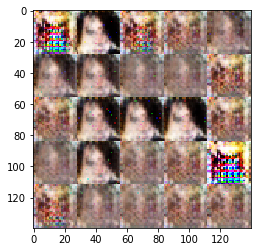

Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 4.1375
Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 4.5379
Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 4.1860
Epoch 1/1... Discriminator Loss: 0.3407... Generator Loss: 4.5304
Epoch 1/1... Discriminator Loss: 0.3386... Generator Loss: 4.4102
Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 4.8700
Epoch 1/1... Discriminator Loss: 0.3329... Generator Loss: 4.9857
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 4.5500
Epoch 1/1... Discriminator Loss: 0.3337... Generator Loss: 5.0372
Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 4.3227


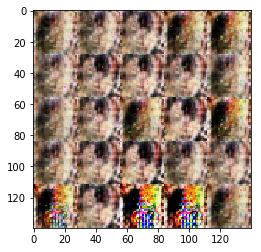

Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 4.8406
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 4.0122
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 5.0280
Epoch 1/1... Discriminator Loss: 0.3399... Generator Loss: 4.4508
Epoch 1/1... Discriminator Loss: 0.3394... Generator Loss: 4.3617
Epoch 1/1... Discriminator Loss: 0.3313... Generator Loss: 5.3263
Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 5.3974
Epoch 1/1... Discriminator Loss: 0.3318... Generator Loss: 4.9873
Epoch 1/1... Discriminator Loss: 0.3297... Generator Loss: 6.0918
Epoch 1/1... Discriminator Loss: 0.3375... Generator Loss: 3.0755


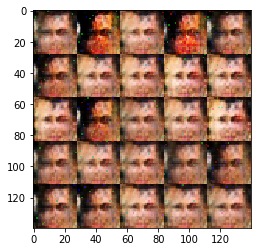

Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 5.9062
Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 4.9660
Epoch 1/1... Discriminator Loss: 0.3280... Generator Loss: 6.2069
Epoch 1/1... Discriminator Loss: 0.3318... Generator Loss: 4.6199
Epoch 1/1... Discriminator Loss: 0.3290... Generator Loss: 5.6281
Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 5.3987
Epoch 1/1... Discriminator Loss: 0.3320... Generator Loss: 4.8163
Epoch 1/1... Discriminator Loss: 0.3280... Generator Loss: 5.5157
Epoch 1/1... Discriminator Loss: 0.3334... Generator Loss: 5.8951
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 6.0040


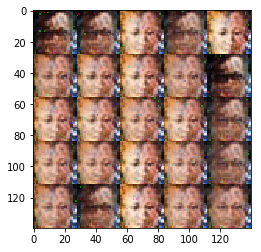

Epoch 1/1... Discriminator Loss: 0.3284... Generator Loss: 5.7535
Epoch 1/1... Discriminator Loss: 0.3283... Generator Loss: 6.6731
Epoch 1/1... Discriminator Loss: 0.3313... Generator Loss: 4.9520
Epoch 1/1... Discriminator Loss: 0.3299... Generator Loss: 5.4943
Epoch 1/1... Discriminator Loss: 0.3393... Generator Loss: 5.7123
Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 5.5246
Epoch 1/1... Discriminator Loss: 0.3297... Generator Loss: 4.3589
Epoch 1/1... Discriminator Loss: 0.3336... Generator Loss: 5.4136
Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 5.8479
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 5.4919


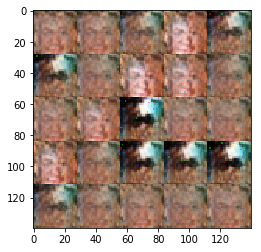

Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 4.1683
Epoch 1/1... Discriminator Loss: 0.3310... Generator Loss: 6.1242
Epoch 1/1... Discriminator Loss: 0.3281... Generator Loss: 6.7520
Epoch 1/1... Discriminator Loss: 0.3279... Generator Loss: 6.7704
Epoch 1/1... Discriminator Loss: 0.3314... Generator Loss: 6.4869
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 6.0207
Epoch 1/1... Discriminator Loss: 0.3609... Generator Loss: 4.8609
Epoch 1/1... Discriminator Loss: 0.3279... Generator Loss: 5.1225
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 4.5267
Epoch 1/1... Discriminator Loss: 0.3294... Generator Loss: 6.1147


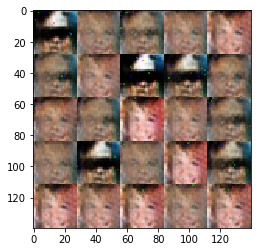

KeyboardInterrupt: 

In [23]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.